In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib
import matplotlib.pyplot as plt
from awkward import JaggedArray
import awkward
from FireHydrant.Tools.uproothelpers import fromNestNestIndexArray

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
datasets_v1 = {
    'mXX-100_mA-5_lxy-300': [
        "root://cmseos.fnal.gov//eos/uscms/store/group/lpcmetx/SIDM/ffNtuple/2018/CRAB_PrivateMC/SIDM_BsTo2DpTo2Mu2e_MBs-100_MDp-5_ctau-375/191015_121303/ffNtuple_0.root",
        "root://cmseos.fnal.gov//eos/uscms/store/group/lpcmetx/SIDM/ffNtuple/2018/CRAB_PrivateMC/SIDM_BsTo2DpTo2Mu2e_MBs-100_MDp-5_ctau-375/191015_121303/ffNtuple_1.root",
        "root://cmseos.fnal.gov//eos/uscms/store/group/lpcmetx/SIDM/ffNtuple/2018/CRAB_PrivateMC/SIDM_BsTo2DpTo2Mu2e_MBs-100_MDp-5_ctau-375/191015_121303/ffNtuple_2.root",
        "root://cmseos.fnal.gov//eos/uscms/store/group/lpcmetx/SIDM/ffNtuple/2018/CRAB_PrivateMC/SIDM_BsTo2DpTo2Mu2e_MBs-100_MDp-5_ctau-375/191015_121303/ffNtuple_3.root",
        "root://cmseos.fnal.gov//eos/uscms/store/group/lpcmetx/SIDM/ffNtuple/2018/CRAB_PrivateMC/SIDM_BsTo2DpTo2Mu2e_MBs-100_MDp-5_ctau-375/191015_121303/ffNtuple_4.root"
    ]
}

datasets_v2 = {
    'mXX-100_mA-5_lxy-300': [
        "root://cmseos.fnal.gov//eos/uscms/store/group/lpcmetx/SIDM/ffNtupleV2/2018/CRAB_PrivateMC/SIDM_BsTo2DpTo2Mu2e_MBs-100_MDp-5_ctau-375/191014_150221/ffNtuple_0.root",
        "root://cmseos.fnal.gov//eos/uscms/store/group/lpcmetx/SIDM/ffNtupleV2/2018/CRAB_PrivateMC/SIDM_BsTo2DpTo2Mu2e_MBs-100_MDp-5_ctau-375/191014_150221/ffNtuple_1.root",
        "root://cmseos.fnal.gov//eos/uscms/store/group/lpcmetx/SIDM/ffNtupleV2/2018/CRAB_PrivateMC/SIDM_BsTo2DpTo2Mu2e_MBs-100_MDp-5_ctau-375/191014_150221/ffNtuple_2.root",
        "root://cmseos.fnal.gov//eos/uscms/store/group/lpcmetx/SIDM/ffNtupleV2/2018/CRAB_PrivateMC/SIDM_BsTo2DpTo2Mu2e_MBs-100_MDp-5_ctau-375/191014_150221/ffNtuple_3.root",
        "root://cmseos.fnal.gov//eos/uscms/store/group/lpcmetx/SIDM/ffNtupleV2/2018/CRAB_PrivateMC/SIDM_BsTo2DpTo2Mu2e_MBs-100_MDp-5_ctau-375/191014_150221/ffNtuple_4.root"
    ]
}

In [3]:
class recoEfficiencyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        binning = np.concatenate([np.arange(0, 1, 0.1),
                                  np.arange(1,10,1),
                                  np.arange(10,100, 5),
                                  np.arange(100, 300, 10),
                                  np.arange(300, 600, 25)
                                 ])
        dpvxy_axis = hist.Bin('dpvxy', 'darkphoton lxy [cm]', binning)
        reco_axis = hist.Cat('recoed', 'recoed')
        type_axis = hist.Cat('type', 'decay product')
        self._accumulator = processor.dict_accumulator({
            'dpvxy': hist.Hist("Counts", dataset_axis, dpvxy_axis, reco_axis, type_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        npfel = (ljdautype==2).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        # leptonjets.add_attributes(label=label)
        leptonjets.add_attributes(hasel=(npfel!=0))
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            daupid=df['gen_daupid'].content,
            dauvx=df['gen_dauvtx.fCoordinates.fX'].content,
            dauvy=df['gen_dauvtx.fCoordinates.fY'].content,
            dauvz=df['gen_dauvtx.fCoordinates.fZ'].content,
        )

        is_dpToEl = (genparticles.pid==32)&(genparticles.daupid==11)
        is_dpToMu = (genparticles.pid==32)&(genparticles.daupid==13)
        darkphotons_el = genparticles[is_dpToEl]
        darkphotons_mu = genparticles[is_dpToMu]

        recomask_el = darkphotons_el.match(leptonjets, deltaRCut=0.4)
        recomask_mu = darkphotons_mu.match(leptonjets, deltaRCut=0.4)
        
        recomask_el_e = darkphotons_el.match(leptonjets[leptonjets.hasel], deltaRCut=0.4)
        recomask_el_g = darkphotons_el.match(leptonjets[~leptonjets.hasel], deltaRCut=0.4)
        
        gendaurho = np.hypot(genparticles.dauvx, genparticles.dauvy)
        
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][recomask_el].flatten(),
                             recoed='true', type='el')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][~recomask_el].flatten(),
                             recoed='false', type='el')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][recomask_el_e].flatten(),
                             recoed='true', type='el_e')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][recomask_el_g].flatten(),
                             recoed='true', type='el_g')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToMu][recomask_mu].flatten(),
                             recoed='true', type='mu')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToMu][~recomask_mu].flatten(),
                             recoed='false', type='mu')
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets_v1,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=recoEfficiencyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:03<00:00,  1.66items/s]


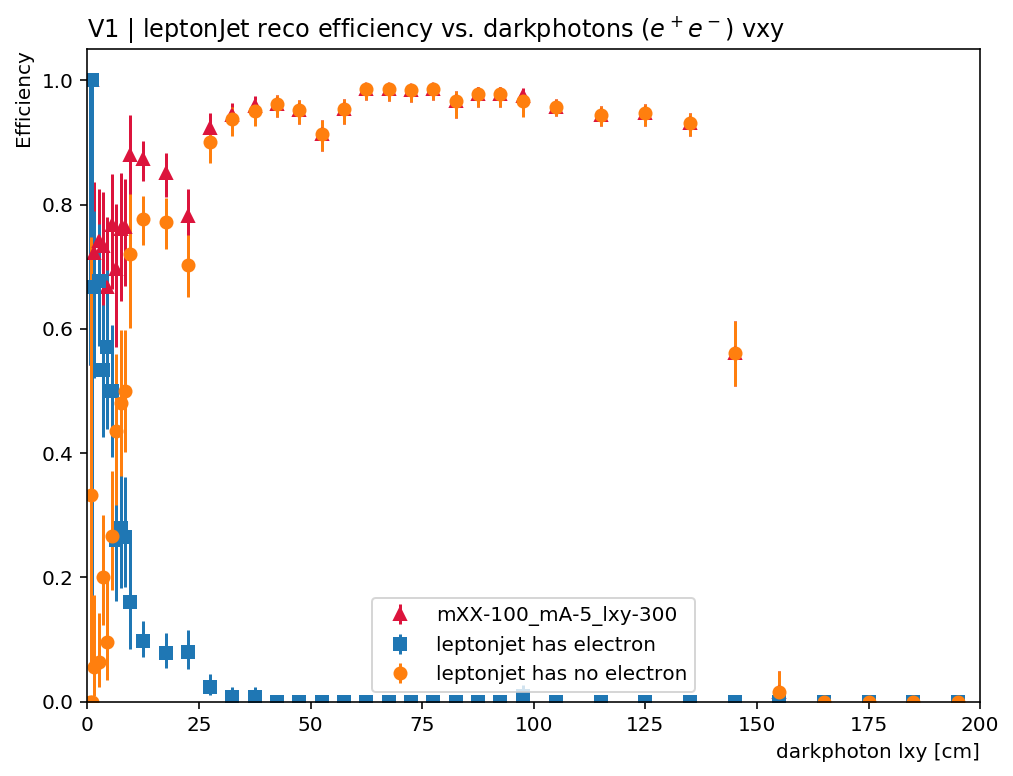

In [6]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
hist.plotratio(num=output['dpvxy'].integrate('type', 'el').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': '^', 'color': 'crimson'},
               unc='clopper-pearson',
               ax=ax,
               label='mXX-100_mA-5_lxy-300')
hist.plotratio(num=output['dpvxy'].integrate('type', 'el_e').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': 's'},
               unc='clopper-pearson',
               ax=ax,
               clear=False,
               label='leptonjet has electron')
hist.plotratio(num=output['dpvxy'].integrate('type', 'el_g').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': 'o'},
               unc='clopper-pearson',
               ax=ax,
               clear=False,
               label='leptonjet has no electron')
ax.set_title('V1 | leptonJet reco efficiency vs. darkphotons ($e^+e^-$) vxy', x=0.0, ha="left")

ax.legend()
# ax.autoscale(tight=True)
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 200)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

In [7]:
output = processor.run_uproot_job(datasets_v2,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=recoEfficiencyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:03<00:00,  1.66items/s]


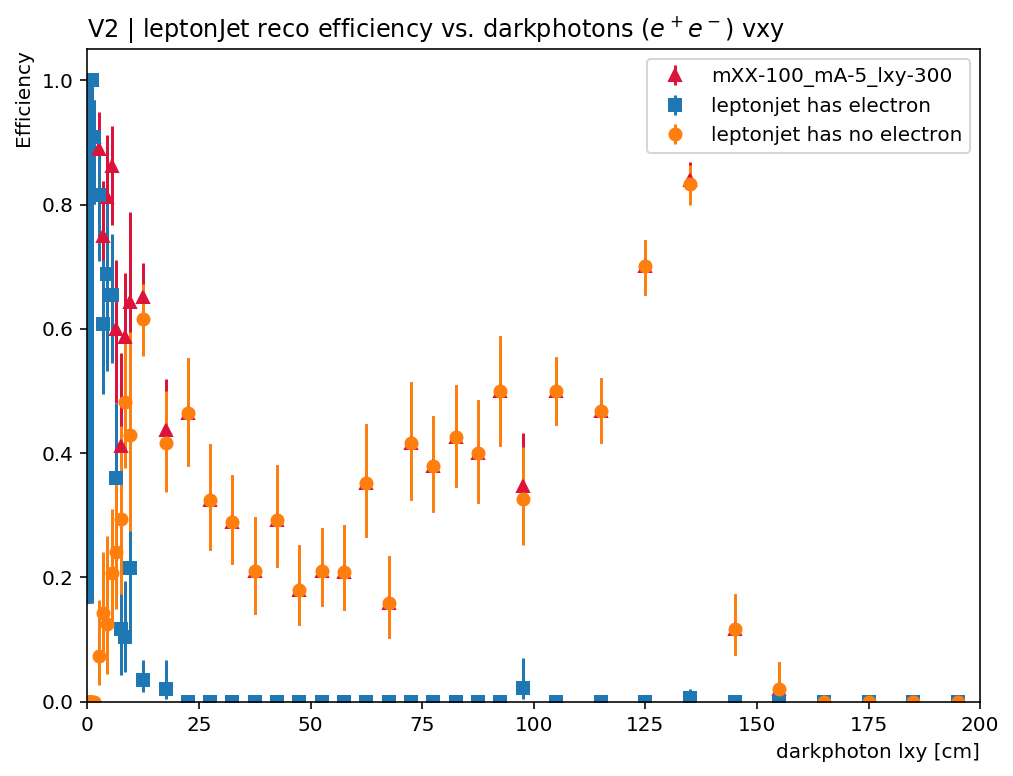

In [8]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
hist.plotratio(num=output['dpvxy'].integrate('type', 'el').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': '^', 'color': 'crimson'},
               unc='clopper-pearson',
               ax=ax,
               label='mXX-100_mA-5_lxy-300')
hist.plotratio(num=output['dpvxy'].integrate('type', 'el_e').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': 's'},
               unc='clopper-pearson',
               ax=ax,
               clear=False,
               label='leptonjet has electron')
hist.plotratio(num=output['dpvxy'].integrate('type', 'el_g').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': 'o'},
               unc='clopper-pearson',
               ax=ax,
               clear=False,
               label='leptonjet has no electron')
ax.set_title('V2 | leptonJet reco efficiency vs. darkphotons ($e^+e^-$) vxy', x=0.0, ha="left")

ax.legend()
# ax.autoscale(tight=True)
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 200)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

In [9]:
class recoEfficiencyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        binning = np.concatenate([np.arange(0, 1, 0.1),
                                  np.arange(1,10,1),
                                  np.arange(10,100, 5),
                                  np.arange(100, 300, 10),
                                  np.arange(300, 600, 25)
                                 ])
        dpvxy_axis = hist.Bin('dpvxy', 'darkphoton lxy [cm]', binning)
        reco_axis = hist.Cat('recoed', 'recoed')
        type_axis = hist.Cat('type', 'decay product')
        self._accumulator = processor.dict_accumulator({
            'dpvxy': hist.Hist("Counts", dataset_axis, dpvxy_axis, reco_axis, type_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        npfel = (ljdautype==2).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        # leptonjets.add_attributes(label=label)
        leptonjets.add_attributes(hasel=(npfel!=0))
        
        ljphoidx = awkward.fromiter(df['pfjet_pfcand_photonIdx'])
        haspfpho = (JaggedArray.fromoffsets(ljphoidx.offsets, ljphoidx.flatten().counts)>0)
        ljphoIDbit = fromNestNestIndexArray(df['photon_idBit'], ljphoidx)
        passlooseid = ljphoIDbit>=15
        leptonjets.add_attributes(photonlooseid=(haspfpho&passlooseid.all()))
        
        
#         leptonjets = leptonjets[isegammajet&(npfel==0)&(haspfpho)]
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            daupid=df['gen_daupid'].content,
            dauvx=df['gen_dauvtx.fCoordinates.fX'].content,
            dauvy=df['gen_dauvtx.fCoordinates.fY'].content,
            dauvz=df['gen_dauvtx.fCoordinates.fZ'].content,
        )

        is_dpToEl = (genparticles.pid==32)&(genparticles.daupid==11)
        is_dpToMu = (genparticles.pid==32)&(genparticles.daupid==13)
        darkphotons_el = genparticles[is_dpToEl]
        darkphotons_mu = genparticles[is_dpToMu]

        recomask_el = darkphotons_el.match(leptonjets[isegammajet&(npfel==0)], deltaRCut=0.4)
        recomask_mu = darkphotons_mu.match(leptonjets, deltaRCut=0.4)
        
#         recomask_el_e = darkphotons_el.match(leptonjets[leptonjets.hasel], deltaRCut=0.4)
#         recomask_el_g = darkphotons_el.match(leptonjets[~leptonjets.hasel], deltaRCut=0.4)
        
        gendaurho = np.hypot(genparticles.dauvx, genparticles.dauvy)
        
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][recomask_el].flatten(),
                             recoed='true', type='el')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][~recomask_el].flatten(),
                             recoed='false', type='el')
        
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][ darkphotons_el.match(leptonjets[isegammajet&(npfel==0)&(haspfpho)], deltaRCut=0.4) ].flatten(),
                             recoed='true', type='00')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][ darkphotons_el.match(leptonjets[isegammajet&(npfel==0)&(haspfpho)&np.bitwise_and(ljphoIDbit, 1<<2).all()], deltaRCut=0.4) ].flatten(),
                             recoed='true', type='2')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][ darkphotons_el.match(leptonjets[isegammajet&(npfel==0)&(haspfpho)&np.bitwise_and(ljphoIDbit, 1<<3).all()], deltaRCut=0.4) ].flatten(),
                             recoed='true', type='3')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][ darkphotons_el.match(leptonjets[isegammajet&(npfel==0)&(haspfpho)&np.bitwise_and(ljphoIDbit, 1<<4).all()], deltaRCut=0.4) ].flatten(),
                             recoed='true', type='4')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][ darkphotons_el.match(leptonjets[isegammajet&(npfel==0)&(haspfpho)&np.bitwise_and(ljphoIDbit, 1<<5).all()], deltaRCut=0.4) ].flatten(),
                             recoed='true', type='5')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][ darkphotons_el.match(leptonjets[isegammajet&(npfel==0)&(haspfpho)&np.bitwise_and(ljphoIDbit, 1<<6).all()], deltaRCut=0.4) ].flatten(),
                             recoed='true', type='6')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToEl][ darkphotons_el.match(leptonjets[isegammajet&(npfel==0)&(haspfpho)&(ljphoIDbit>=127).all()], deltaRCut=0.4) ].flatten(),
                             recoed='true', type='loose')

        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToMu][recomask_mu].flatten(),
                             recoed='true', type='mu')
        output['dpvxy'].fill(dataset=dataset,
                             dpvxy=gendaurho[is_dpToMu][~recomask_mu].flatten(),
                             recoed='false', type='mu')
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [48]:
# import uproot
# t=uproot.open(datasets_v1['mXX-100_mA-5_lxy-300'][0])['ffNtuplizer/ffNtuple']
# val=t['photon_idBit'].array()
# idx=awkward.fromiter(t['pfjet_pfcand_photonIdx'].array())

In [57]:
# print(*awkward.fromiter(t['pfjet_pfcand_photonIdx'].array()))
# print(idx)
# print(JaggedArray.fromoffsets(idx.offsets, idx.flatten().counts))

[[[] []] [[]] [[0]] ... [[]] [[]] [[]]]
[[0 0] [0] [1] ... [0] [0] [0]]


In [10]:
output = processor.run_uproot_job(datasets_v1,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=recoEfficiencyProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:03<00:00,  1.66items/s]


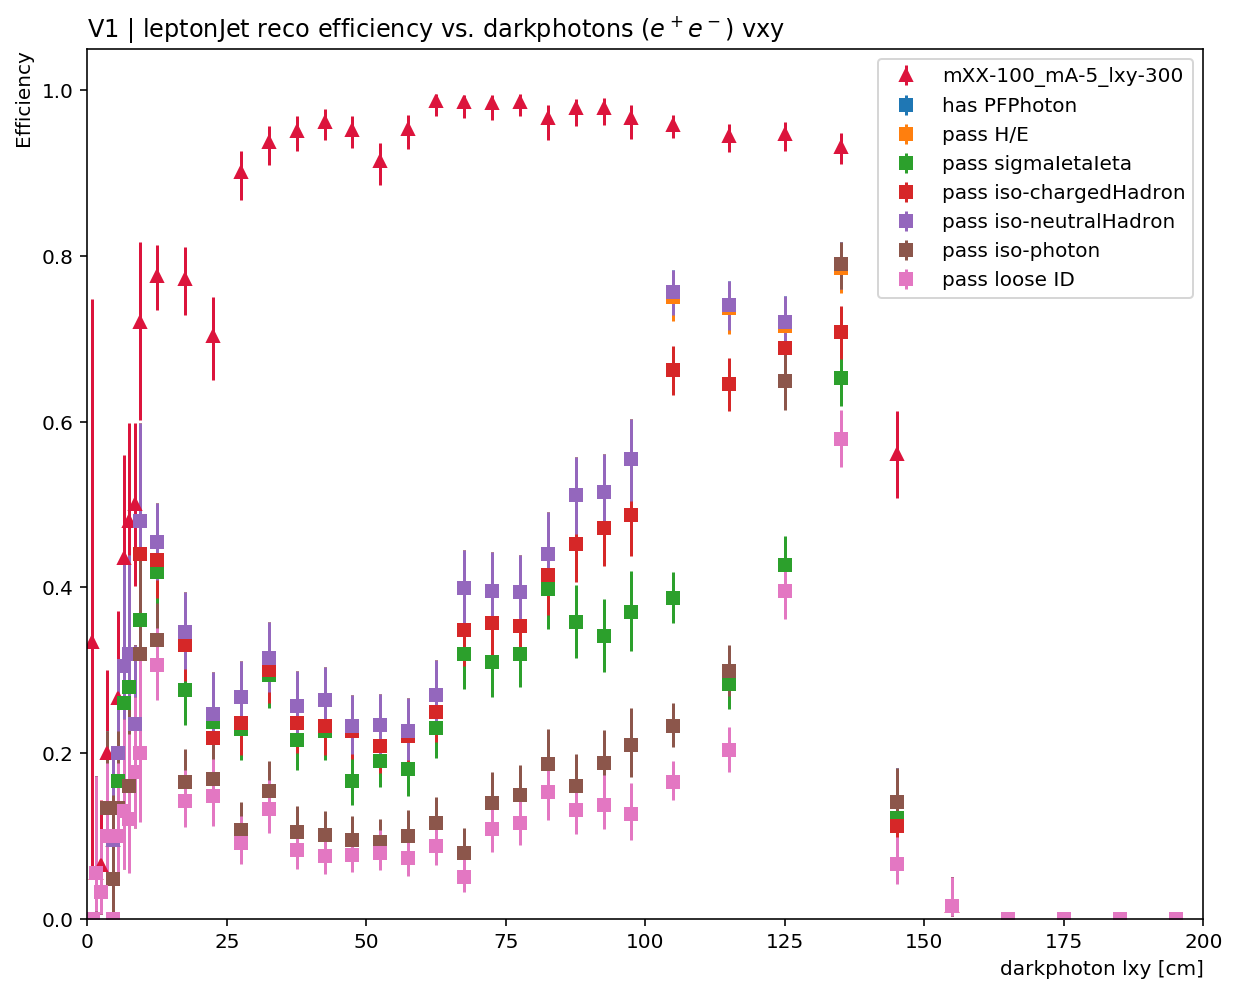

In [11]:
fig,ax=plt.subplots(1,1,figsize=(10,8))
hist.plotratio(num=output['dpvxy'].integrate('type', 'el').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': '^', 'color': 'crimson'},
               unc='clopper-pearson',
               ax=ax,
               label='mXX-100_mA-5_lxy-300')
hist.plotratio(num=output['dpvxy'].integrate('type', '00').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': 's'},
               unc='clopper-pearson',
               ax=ax,
               clear=False,
               label='has PFPhoton')
hist.plotratio(num=output['dpvxy'].integrate('type', '2').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': 's'},
               unc='clopper-pearson',
               ax=ax,
               clear=False,
               label='pass H/E')
hist.plotratio(num=output['dpvxy'].integrate('type', '3').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': 's'},
               unc='clopper-pearson',
               ax=ax,
               clear=False,
               label='pass sigmaIetaIeta')
hist.plotratio(num=output['dpvxy'].integrate('type', '4').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': 's'},
               unc='clopper-pearson',
               ax=ax,
               clear=False,
               label='pass iso-chargedHadron')
hist.plotratio(num=output['dpvxy'].integrate('type', '5').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': 's'},
               unc='clopper-pearson',
               ax=ax,
               clear=False,
               label='pass iso-neutralHadron')
hist.plotratio(num=output['dpvxy'].integrate('type', '6').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': 's'},
               unc='clopper-pearson',
               ax=ax,
               clear=False,
               label='pass iso-photon')
hist.plotratio(num=output['dpvxy'].integrate('type', 'loose').integrate('recoed', 'true').sum('dataset'),
               denom=output['dpvxy'].integrate('type', 'el').sum('recoed').sum('dataset'),
               error_opts={'marker': 's'},
               unc='clopper-pearson',
               ax=ax,
               clear=False,
               label='pass loose ID')
ax.set_title('V1 | leptonJet reco efficiency vs. darkphotons ($e^+e^-$) vxy', x=0.0, ha="left")

ax.legend()
# ax.autoscale(tight=True)
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 200)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");